### Loading the entire dataset, Scaling data points and splitting data
##### Including removing the inf and nan values in the dataset with the median values of their respective feature columns


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

df = pd.read_csv("CICIDS2017_Wednesday_Paper.csv")
df.columns=df.columns.str.strip()
df = df[df['Label'] != 'Heartbleed']

#Replacing the 4 'nan' values in the 'Flow Bytes/s' feature with the median of all values
df["Flow Bytes/s"].replace(np.nan, np.median(df["Flow Bytes/s"].dropna()),inplace=True)
#There are 30 and 34 inifinite values in the 'Flow Bytes/s' and ' Flow Packets/s', respectively.
df.replace(np.inf,np.nan,inplace=True) #We first change inf values to nan values since I find them easier to delete
df["Flow Bytes/s"].replace(np.nan, np.max(df["Flow Bytes/s"].dropna()) ,inplace=True) #Then we are changing them with the max value in the column
df["Flow Packets/s"].replace(np.nan, np.max(df["Flow Packets/s"].dropna()) ,inplace=True)
df.replace(["BENIGN","DoS Hulk","DoS GoldenEye","DoS slowloris","DoS Slowhttptest"],[0,1,2,3,4],inplace=True)

X = MinMaxScaler().fit_transform(df.drop(['Label'],axis=1))
y=df["Label"]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state=42)

C:\Users\dyari\AppData\Local\Temp\ipykernel_8484\3885227182.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Flow Bytes/s"].replace(np.nan, np.median(df["Flow Bytes/s"].dropna()),inplace=True)
C:\Users\dyari\AppData\Local\Temp\ipykernel_8484\3885227182.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting va

### Training the MLP model

In [5]:
from sklearn.neural_network import MLPClassifier
import time

clf = MLPClassifier(hidden_layer_sizes=(100,200,250),
                    max_iter=50,solver="adam",
                    verbose=True,activation='relu',
                    learning_rate_init=0.01)

start_time = time.time()
# Fit data onto the model
clf.fit(X_train,y_train)

end_time = time.time()
elapsed_time = end_time - start_time

Iteration 1, loss = 0.04159051
Iteration 2, loss = 0.02166825
Iteration 3, loss = 0.01922976
Iteration 4, loss = 0.01969698
Iteration 5, loss = 0.01961910
Iteration 6, loss = 0.01769640
Iteration 7, loss = 0.01752972
Iteration 8, loss = 0.01804180
Iteration 9, loss = 0.01745917
Iteration 10, loss = 0.01652405
Iteration 11, loss = 0.01700080
Iteration 12, loss = 0.01655241
Iteration 13, loss = 0.01648850
Iteration 14, loss = 0.01683301
Iteration 15, loss = 0.01742431
Iteration 16, loss = 0.01630173
Iteration 17, loss = 0.01639763
Iteration 18, loss = 0.01622139
Iteration 19, loss = 0.01647402
Iteration 20, loss = 0.01646306
Iteration 21, loss = 0.01633180
Iteration 22, loss = 0.01655514
Iteration 23, loss = 0.01598099
Iteration 24, loss = 0.01595725
Iteration 25, loss = 0.01644862
Iteration 26, loss = 0.01662708
Iteration 27, loss = 0.01543710
Iteration 28, loss = 0.01641499
Iteration 29, loss = 0.01604267
Iteration 30, loss = 0.01585364
Iteration 31, loss = 0.01625764
Iteration 32, los

### Predictions BEFORE sample modification

Accuracy: 0.9969250535950166
---------------------------------------------------------


array([[87714,   277,    39,    12,    29],
       [   12, 46175,    31,     0,     0],
       [    1,     0,  2043,     0,     2],
       [    4,     1,     0,  1104,     5],
       [    5,     0,     2,     6,  1077]], dtype=int64)

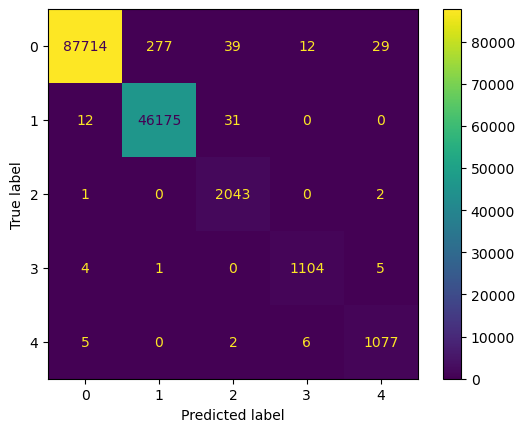

In [7]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,f1_score,recall_score

y_pred=clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test,y_pred))
print("---------------------------------------------------------")

BeforePerturbation = ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
BeforePerturbation.confusion_matrix

### Sample modification - Both Benign and Malicious Shuffle

In [9]:
import random

#Identify the unique 'Flow IAT Mean' values of all classes
unique_values = df['Flow IAT Mean'].unique()

def SystematicShuffling(X, y, feature='Flow IAT Mean'):
    # Ensure X and y are pandas DataFrames and Series
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X, columns=df.drop(columns=['Label']).columns)
    if isinstance(y, np.ndarray):
        y = pd.Series(y)

    X_copy = X.copy()
    y_copy = y.copy()

    # Loop through the dataset
    for idx in range(len(X)):
        X_copy.loc[idx, feature] = random.choice(unique_values)

    return X_copy, y_copy


X_evasive3, y_evasive3 = SystematicShuffling(X_test, y_test, feature='Flow IAT Mean')

### Predictions After sample modification - Both Benign and Malicious Shuffle

C:\Users\dyari\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


Accuracy: 0.3336677758609489


array([[    9, 88057,     5,     0,     0],
       [    0, 46215,     3,     0,     0],
       [    0,  2045,     1,     0,     0],
       [    0,  1113,     0,     1,     0],
       [    0,  1090,     0,     0,     0]], dtype=int64)

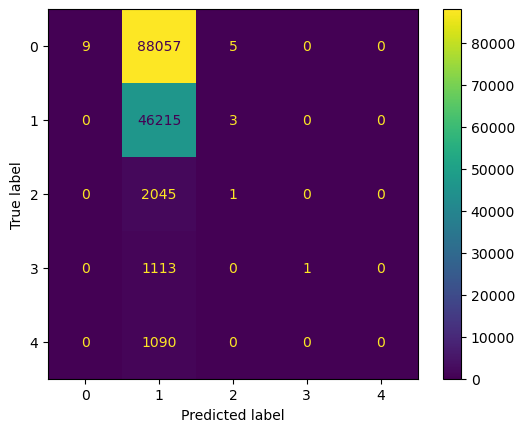

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,f1_score,recall_score

y_pred3_evasive = clf.predict(X_evasive3)
print("Accuracy:", accuracy_score(y_evasive3,y_pred3_evasive))

Perturb03=ConfusionMatrixDisplay.from_predictions(y_evasive3, y_pred3_evasive)
Perturb03.confusion_matrix